the dataset consists of the data gathered by walking around the block with WiGLE

the task
- filter data by different criteria, plot on the map
- explore device vendor distribution

In [ ]:
import numpy as np
import pandas as pd
import time
import folium
from folium import Map, Marker
import random
import seaborn as sns
import matplotlib.pyplot as plt
color_list = ['black', 'darkblue', 'cadetblue', 'pink', 'darkred', 'white', 'orange', 'purple', 'lightblue', 'darkpurple', 'gray', 'red', 'lightgray', 'lightred', 'green', 'darkgreen', 'beige', 'lightgreen', 'blue']
from tqdm import tqdm
import time
plt.rcParams['font.sans-serif'] = ['STSong'] #Set the font to correctly show labels in Chinese
plt.rcParams['axes.unicode_minus'] = False
import datetime

In [ ]:
def importdataset():
    wd = pd.read_csv ('WigleWifi_20210908205108.csv', parse_dates=["FirstSeen"], skiprows=1) 
    wd["Channel"] = wd["Channel"].astype('int16') #from -32,768 to 32,767
    wd["RSSI"] = wd["RSSI"].astype('int8') #from -128 to 127
    print(f"total {len(wd)} devices") # number of detected devices
    return wd

# explore and clean the data

In [ ]:
#reload the data
wd = importdataset()
wd.sample(5)

In [ ]:
wd["MAC"].value_counts()

In [ ]:
#take a look how many unique valid MACs are there and how many entries in total
wd.loc[(wd['MAC'].str.len() == 17)]["MAC"].describe()

In [ ]:
print(f"number of unique APs: {len(wd['MAC'].unique())}")

In [ ]:
pd.DataFrame (wd['MAC'].unique())

In [ ]:
pd.DataFrame (wd.loc[(wd['MAC'].str.len() == 17)]["MAC"])

# plot all WCDMA towers

In [ ]:
wd = importdataset()
wd.sample(5)

In [ ]:
# drop all else except WCDMA
wd = pd.DataFrame( wd.loc[wd['Type'] == "WCDMA"] )
wd = wd.reset_index(drop=True)
wd.sample(5)

In [ ]:
wd['MAC'].value_counts()

In [ ]:
#color code different MACs
wd["Color"] = None
for index, row in wd.iterrows():
    if wd['Color'][index] == None:
        wd.loc[wd['MAC'] == wd['MAC'][index],"Color"] = random.choice(color_list)

In [ ]:
pd.DataFrame (wd, columns=['Color','MAC']).value_counts()

In [ ]:
# map code source：https://github.com/AlexLynd/ESP8266-Wardriving
# manually set thestarting point for map display at the coordinates of the first detected device
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17) 

# add the route to the plot
# folium.PolyLine(wd[['CurrentLatitude', 'CurrentLongitude']].values.tolist(),line_opacity = 0.5, weight = 4).add_to(basic_map) 

# add markers for every point in dataset 
for i in range(len(wd)): 
#     if wd["FirstSeen"][i] > "2021-8-21 18:43:25" and wd["FirstSeen"][i] < "2021-8-21 18:46:58": # add time filter
#     if wd["RSSI"][i] > 10:
    if wd.loc[wd['MAC'] == wd['MAC'][i],"RSSI"].max() == wd["RSSI"][i]:# only plot with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i] 
        folium.Marker( location=[lat, lon], tooltip=f'MAC {wd["MAC"][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color=wd["Color"][i], prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total towers: {len(wd['MAC'].unique())}")        
display(basic_map)

# 

# 

# 

# plot all WIFI APs with highest signal strength

In [ ]:
wd = importdataset()
wd.sample(5)

In [ ]:
#drop everything except those having valid MACs
wd = wd.loc[(wd['MAC'].str.len() == 17)]
wd = wd.reset_index(drop=True)
wd.sample(5)

In [ ]:
wd.info()

In [ ]:
print(f"total APs: {len(wd['MAC'].unique())}") 

In [ ]:
# map code source：https://github.com/AlexLynd/ESP8266-Wardriving
LOOKING_FOR = 'SSID'
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17)

# add markers for every point in dataset 
for i in range(len(wd)): 
    if wd.loc[wd[LOOKING_FOR] == wd[LOOKING_FOR][i],"RSSI"].max() == wd["RSSI"][i]: # only plot AP with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i]
        folium.Marker( location=[lat, lon], tooltip=f'{LOOKING_FOR} {wd[LOOKING_FOR][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color="blue", prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total APs: {len(wd['MAC'].unique())}")    
display(basic_map)

# 

# 

# 

# 

# plot all WPS-enabled wifi with highest signal strength

In [ ]:
wd = importdataset()
wd.sample(5)

In [ ]:
wd['AuthMode'].value_counts()

In [ ]:
# make a sorted list of authmodes used
wd_sorted_list = pd.DataFrame (wd, columns=['AuthMode']).value_counts().rename_axis('Auth_sorted').reset_index(name='counts')
wd_sorted_list

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = wd_sorted_list['Auth_sorted']
sizes = wd_sorted_list['counts']

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
ap_use_wps=len(pd.DataFrame( wd.loc[(wd['AuthMode'].str.contains('WPS')==True)]))
ap_other=len(wd)-ap_use_wps
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "other APs", "APs that use WPS"
sizes = [ap_other, ap_use_wps]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# drop all except those that use WPS
wd = pd.DataFrame( wd.loc[lambda x: (wd['AuthMode'].str.contains('WPS')==True), :])
wd = wd.reset_index(drop=True)
wd.sample(5)

In [ ]:
wd.info()

In [ ]:
wd['AuthMode'].value_counts()

In [ ]:
# make a sorted list of authmodes used
wd_sorted_list = pd.DataFrame (wd, columns=['AuthMode']).value_counts().rename_axis('Auth_sorted').reset_index(name='counts')
wd_sorted_list

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = wd_sorted_list['Auth_sorted']
sizes = wd_sorted_list['counts']

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
#color code authmodes
wd["Color"] = None
for index, row in wd.iterrows():
    if wd['Color'][index] == None:
        wd.loc[wd['AuthMode'] == wd['AuthMode'][index],"Color"] = random.choice(color_list)

In [ ]:
pd.DataFrame (wd, columns=['Color','AuthMode']).value_counts()

In [ ]:
# map code source：https://github.com/AlexLynd/ESP8266-Wardriving
LOOKING_FOR = 'SSID'
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17)

# add markers for every point in dataset 
for i in range(len(wd)): 

    if wd.loc[wd[LOOKING_FOR] == wd[LOOKING_FOR][i],"RSSI"].max() == wd["RSSI"][i]: # only plot AP with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i]
        folium.Marker( location=[lat, lon], tooltip=f'{LOOKING_FOR} {wd[LOOKING_FOR][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color=wd["Color"][i], prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total APs: {len(wd['MAC'].unique())}")    
display(basic_map)

### again, filter by those using WEP

In [ ]:
wd = importdataset()

In [ ]:
wd = pd.DataFrame( wd.loc[lambda x: (wd['AuthMode'].str.contains('WEP')==True), :])
wd = wd.reset_index(drop=True)

In [ ]:
wd['AuthMode'].value_counts()

In [ ]:
wd

### another filter

In [ ]:
wd = importdataset()

In [ ]:
wd = pd.DataFrame( wd.loc[~(wd['AuthMode'].str.contains('\[')==True)&~(wd['AuthMode'].str.contains('WCDMA')==True), :])
wd = wd.reset_index(drop=True)

In [ ]:
wd['AuthMode'].value_counts()

In [ ]:
wd

### another filter

In [ ]:
wd = importdataset()

In [ ]:
wd.loc[(wd['Type'].str.contains('B')==True)]

In [ ]:
wd.loc[(wd['Type'].str.contains('GSM')==True)]

### plot GSM

In [ ]:
wd = importdataset()

In [ ]:
wd = pd.DataFrame( wd.loc[(wd['Type'].str.contains('GSM')==True), :])
wd = wd.reset_index(drop=True)

In [ ]:
wd["Color"] = None
for index, row in wd.iterrows():
    if wd['Color'][index] == None:
        wd.loc[wd['MAC'] == wd['MAC'][index],"Color"] = random.choice(color_list)

In [ ]:
wd

In [ ]:
# map code source：https://github.com/AlexLynd/ESP8266-Wardriving
LOOKING_FOR = 'MAC'
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17)

# add markers for every point in dataset 
for i in range(len(wd)): 
    if wd.loc[wd[LOOKING_FOR] == wd[LOOKING_FOR][i],"RSSI"].max() == wd["RSSI"][i]: # only plot AP with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i]
        folium.Marker( location=[lat, lon], tooltip=f'{LOOKING_FOR} {wd[LOOKING_FOR][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color=wd["Color"][i], prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total APs: {len(wd['MAC'].unique())}")    
display(basic_map)

# find most popular vendors for WiFi devices nearby

In [ ]:
wd = importdataset()

In [ ]:
# https://github.com/AlexLynd/ESP8266-Wardriving/blob/master/mac-vendors.txt
mac_vendors = pd.read_csv ('mac-vendors.csv', names=("MAC", "Vendor"),dtype=object) 
mac_vendors["MAC"]= mac_vendors["MAC"].str.lower()
len(mac_vendors)

In [ ]:
#check how many MACs correspond to a given vendor
# mac_vendors.loc[(mac_vendors['Vendor'].str.contains('TP-LINK'))].sort_values(by='MAC',ascending=True)#.values[0,0]

In [ ]:
#drop everything except those having valid MACs
wd = wd.loc[(wd['MAC'].str.len() == 17)]
wd = wd.drop_duplicates(subset = ["MAC"])
wd = wd.reset_index(drop=True)
len(wd)

In [ ]:
#cut the tail part of the MACs to prepare for merging with the MAC-Vendor regster
wd['MAC'] = wd['MAC'].apply(lambda x: x[:8])

In [ ]:
#OLD CODE
# # find vendors corresponding to the mac addresses and fill 'Vendor' column
# wd['Vendor'] = None
# iterations=0
# start_time = time.time()
# with tqdm(total=len(wd)) as bar:
#     for index, row in wd.iterrows():
#         bar.update(1)
#         if wd.loc[index, 'Vendor'] == None:
#             try:
#                 wd.loc[wd['MAC'].str.startswith(row['MAC'][:8]), 'Vendor'] = mac_vendors.loc[mac_vendors['MAC'] == row['MAC'][:8],"Vendor"].values[0]
#                 iterations+=1
#             except:
#                 pass
# print(f"it took  {time.time()-start_time:.2f} sec. to run the code")           
# print(f"total rows: {len(wd)}, iterations: {iterations}, cells filled: {wd['Vendor'].count()}, unique vendors: {len(wd['Vendor'].unique())}")
# wd.to_feather("with_vendors_added.feather")

In [ ]:
# find vendors corresponding to the mac addresses and fill 'Vendor' column
wd = pd.merge(wd, mac_vendors, on='MAC', how='left')

In [ ]:
#simplifying the plot by cutting off minor vendors (optional)
CUTOFF = 50 #put vendors with less than CUTOFF number of devices into "other" category
def cut_vendors(categories, cutoff):
    categorical_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            categorical_map[categories.index[i]] = categories.index[i]
        else:
            categorical_map[categories.index[i]] = 'Other'
    return categorical_map

vendor_map = cut_vendors(wd["Vendor"].value_counts(), CUTOFF)
wd["Vendor"] = wd["Vendor"].map(vendor_map)

# wd["Vendor"].value_counts()

In [ ]:
# make a sorted list of top vendors
#wd["MAC"]= wd["MAC"].str.lower()
wd_sorted_list = pd.DataFrame (wd, columns=['Vendor']).value_counts().rename_axis('Vendor_sorted').reset_index(name='counts')

#if there are vendors that were grouped into "other" category, rename the category
wd_sorted_list['Vendor_sorted'] = wd_sorted_list['Vendor_sorted'].apply(lambda x: x.replace("Other", "Other vendors"+" (less than "+str(CUTOFF)+" devices of each vendor)"))

# wd_sorted_list

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(7, 7)
fig1.set_dpi(150)
ax1.pie(x=wd_sorted_list['counts'],  labels=wd_sorted_list['Vendor_sorted'], autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('WiFi routers in the neighborhood, vendors distribution', pad=20)
plt.show()
#if there are glyph errors present, rerun the cell to rebuild the cache 

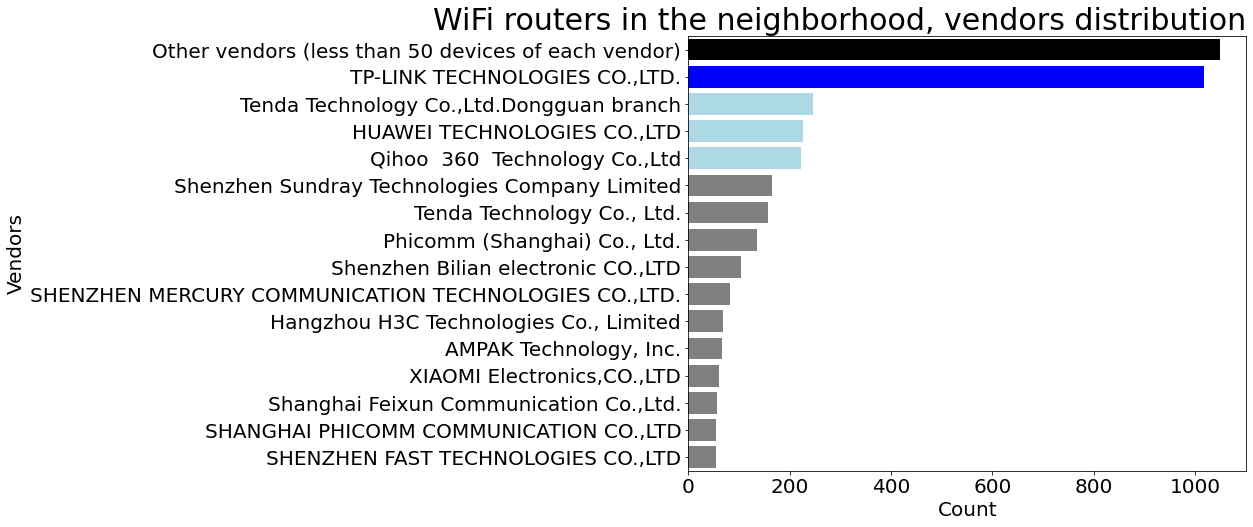

In [148]:
fig = plt.figure(figsize = (10,8))
selective_coloring = ['grey' if (x < max(wd_sorted_list['counts'])) else 'black' for x in wd_sorted_list['counts'] ]
ax = sns.barplot(y=wd_sorted_list['Vendor_sorted'], x=wd_sorted_list['counts'], orient="h", palette = selective_coloring)
ax.set_title("WiFi routers in the neighborhood, vendors distribution",loc='right', fontsize=30)
ax.set_xlabel('Count')
ax.set_ylabel('Vendors')

patch_h = [patch.get_height() for patch in ax.patches]   # patch_h contains the heights of all the patches now
idx_tallest = np.argmax(patch_h)   # np.argmax return the index of largest value of the list
ax.patches[idx_tallest+1].set_facecolor('blue')  
ax.patches[idx_tallest+2].set_facecolor('lightblue') 
ax.patches[idx_tallest+3].set_facecolor('lightblue') 
ax.patches[idx_tallest+4].set_facecolor('lightblue') 
for item in ([ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)   
plt.show()
plt.close()